# Modelos chingones!


In [103]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LinearRegression, Ridge, RidgeCV, LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn import metrics
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import preprocessing
import libpysal as lps # Librería de python para análisis espacial

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal pointsb

In [12]:
base2 = pd.read_pickle(r"./aux_data/tidy_edificios.pkl")

In [22]:
base2 = base2.dropna()

In [32]:
qW = lps.weights.Queen.from_dataframe(base2)
ylag = lps.weights.lag_spatial(qW, base2.loc[:, "AssessedValue_l"])
ylag

array([ 50.95532431,  76.23381993,  50.3388891 , ..., 213.80206919,
        63.28186976,  76.06754334])

In [133]:
?lps.weights

Type:        module
String form: <module 'libpysal.weights' from 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\libpysal\\weights\\__init__.py'>
File:        c:\users\user\anaconda3\lib\site-packages\libpysal\weights\__init__.py
Docstring:   <no docstring>


Definimos la matriz W a partir de la distancia Reina. 

Para las variables espaciales, definimos proximidad como las intersecciones entre los objetos y un radio de 409 metros. Este radio se definió como la distancia mínima en la que al menos todas las observaciones tienen un vecino.

In [49]:
base = base2.drop(['geometry', 'Longitude', 'Latitude'], axis = 1)

In [36]:
ylag = pd.DataFrame(ylag, columns=["ylag"])

In [47]:
base = base.reset_index()

In [58]:
base = pd.concat([base, ylag], axis=1)

**Selecting variables**

1. All variables
2. High pearson correlation
3. Lasso!

In [59]:
cor = base._get_numeric_data().corr()
cor_target = abs(cor["AssessedValue_l"])
relevant_features2 = cor_target[cor_target > 0.5]
relevant_features2

Land Square Feet                                  0.603
Fireplaces                                        0.551
Building Square Feet                              0.623
Prior Tax Year Market Value Estimate (Land)       0.721
Prior Tax Year Market Value Estimate (Building)   0.854
Assessed Value                                    0.909
AssessedValue_l                                   1.000
Name: AssessedValue_l, dtype: float64

In [65]:
X = base.dropna(axis=0).drop(["Assessed Value", "AssessedValue_l"], axis = 1)
y = base.dropna(axis=0)["AssessedValue_l"]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10101)

**Define a cross validation strategy**

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

Standardize the dataset

In [69]:
model = LinearRegression()  
model.fit(X_train, y_train)
y_pred = model.predict(X_test)  

In [70]:
ols_results = pd.DataFrame([{'Actual': y_test, 'Predicted': y_pred}], index = y_test.index)
print("\n OLS score without cross-validation: {:.4f}\n".format(metrics.mean_squared_error(y_test, y_pred))) # ‘neg_mean_squared_error’


 OLS score without cross-validation: 0.0399



In [71]:
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 10101).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [72]:
ols_score = rmsle_cv(model)
print("\n OLS score with cross-validation: {:.4f} ({:.4f})\n".format(ols_score.mean(), ols_score.std()))


 OLS score with cross-validation: 0.2137 (0.0315)



The advantage of cross-validation is that we are more confident about our results because these are not tied to the base partition.  

In [73]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [77]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmsle_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'RMSE')

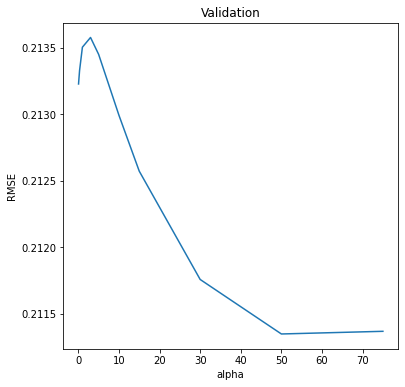

In [138]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("RMSE")

When alpha is too small the regularization model cannot capture all the complexities in the data. Big values of alpha does not cause overfitting in this grid

In [80]:
print("\n Ridge score with cross-validation: {:.4f}\n".format(cv_ridge.min()))


 Ridge score with cross-validation: 0.2113



In [81]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

In [82]:
lasso_score = rmsle_cv(model_lasso).mean()
print("\n Lasso score with cross-validation: {:.4f}\n".format(lasso_score.min()))


 Lasso score with cross-validation: 0.2167



In [83]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 63 variables and eliminated the other 40 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

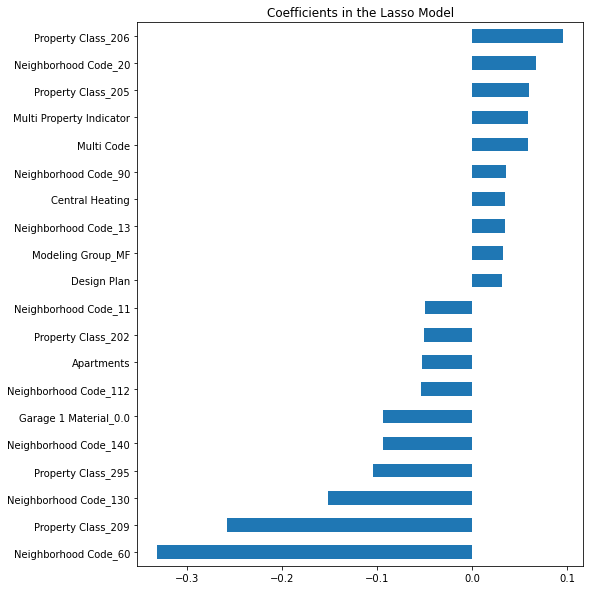

In [84]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

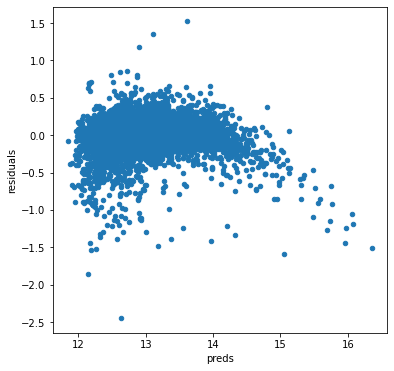

In [85]:
# residuals
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")


In [96]:
lasso = Lasso(alpha = 0.0005, random_state = 10101)
ENet = ElasticNet(alpha= 0.0005, l1_ratio =.9, random_state = 10101)
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                   max_depth = 4, max_features = 'sqrt',
                                   min_samples_leaf = 15, min_samples_split = 10, 
                                   loss = 'huber', random_state = 10101)
model_xgb = xgb.XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468, 
                             learning_rate = 0.05, max_depth = 3, 
                             min_child_weight = 1.7817, n_estimators = 2200,
                             reg_alpha = 0.4640, reg_lambda = 0.8571,
                             subsample = 0.5213, silent = 1,
                             random_state = 10101, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective = 'regression', num_leaves = 5,
                              learning_rate = 0.05, n_estimators = 720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed = 9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
rf = RandomForestRegressor(random_state = 10101)

In [87]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("KRR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.2138 (0.0231)

ElasticNet score: 0.2138 (0.0242)

Gradient Boosting score: 0.1300 (0.0107)

Xgboost score: nan (nan)

LGBM score: nan (nan)



In [97]:
score = rmsle_cv(rf)
print("Random Forest score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

Random Forest score: 0.1733 (0.0322)



In [89]:
n_folds = 10

def rmsle_cv2(model):
    kf = KFold(n_folds, shuffle=True, random_state = 10101).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [91]:
score = rmsle_cv2(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv2(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv2(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv2(rf)
print("Random Forest score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.2677 (0.0769)

ElasticNet score: 0.2683 (0.0769)

Gradient Boosting score: 0.1630 (0.0299)



In [94]:
# Get column names first
names = X.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(X)
X2 = pd.DataFrame(scaled_df, columns = names)

y2 = np.array(y).reshape((len(y), 1))
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(y2)
y3 = pd.DataFrame(scaled_df)

In [99]:
n_folds = 5

def rmsle_cv3(model):
    kf = KFold(n_folds, shuffle=True, random_state = 10101).get_n_splits(X2.values)
    rmse= np.sqrt(-cross_val_score(model, X2, y2, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [100]:
score = rmsle_cv3(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv3(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv3(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv3(rf)
print("Random Forest score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.3076 (0.0651)

ElasticNet score: 0.3088 (0.0650)

Gradient Boosting score: 0.1761 (0.0249)

Random Forest score: 0.1796 (0.0226)



In [128]:
def objective_function_regression(estimator):
    mae_array = cross_val_score( estimator, X_train, y_train, cv= 3, n_jobs=-1, scoring = make_scorer(mae) )
    return np.mean(mae_array)

In [129]:
from sklearn.ensemble import GradientBoostingRegressor
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope

# hyperopt object for 
scope.define(GradientBoostingRegressor)

# search space
n_estimators  = hp.randint('n_estimators', 1000) 
learning_rate = hp.loguniform('learning_rate', -3,1)
max_depth     = hp.randint('max_depth', 10)
max_features =  hp.randint('max_features',X.shape[1]-1)
min_samples_leaf = hp.randint('min_samples_leaf', 10)
                                       
# model / estimator to be optimized
est0 = (0.1, scope.GradientBoostingRegressor(n_estimators  = n_estimators + 1,
                                            learning_rate = learning_rate,
                                            max_depth = max_depth + 1,
                                            max_features = max_features + 1,
                                            min_samples_leaf = min_samples_leaf + 1,
                                            random_state=42) 
        )

# search space
search_space_regression = hp.pchoice('estimator', [est0])

ValueError: ('Cannot override existing symbol', 'GradientBoostingRegressor')

In [132]:
from sklearn.metrics.regression import mean_absolute_error as mae

from sklearn.metrics import make_scorer
best = fmin(
    fn= objective_function_regression,
    space= search_space_regression,
    algo = tpe.suggest, # This is the optimization algorithm hyperopt uses, a tree of parzen estimators
    max_evals = 100,
    verbose = 2  # The number of iterations
         )

print(best)

100%|██████████| 100/100 [31:00<00:00, 18.61s/trial, best loss: 0.07898423331553732]
{'estimator': 0, 'learning_rate': 0.051180221845069505, 'max_depth': 7, 'max_features': 47, 'min_samples_leaf': 2, 'n_estimators': 635}


In [134]:
print(best)

{'estimator': 0, 'learning_rate': 0.051180221845069505, 'max_depth': 7, 'max_features': 47, 'min_samples_leaf': 2, 'n_estimators': 635}


In [135]:
# allocate
Regressor = GradientBoostingRegressor( learning_rate = best['learning_rate'],
                          max_depth = best['max_depth'],
                          max_features = best['max_features'],
                          min_samples_leaf = best['min_samples_leaf'],
                          n_estimators = best['n_estimators'],
                          random_state = 42
                                       )
# fit
Regressor.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.051180221845069505, max_depth=7,
                          max_features=47, min_samples_leaf=2, n_estimators=635,
                          random_state=42)

The MAE on the test set is : 0.07397171375756852


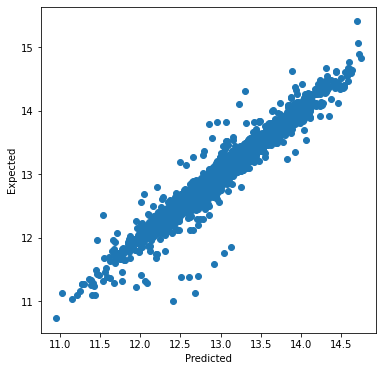

In [136]:
#predict from test set
yhat = Regressor.predict(X_test) ;
print( "{} {}".format('The MAE on the test set is :', mae(y_test, yhat)))

plt.scatter(yhat, y_test); 
plt.ylabel('Expected');plt.xlabel('Predicted')

plt.savefig('foo.png')
plt.show()

[6.94614485e-03 3.46325369e-02 8.60986320e-04 1.08123321e-03
 4.60867403e-04 2.70778355e-04 7.14213980e-03 9.90247208e-04
 1.78186104e-03 1.45566686e-04 5.06354045e-04 5.54644207e-04
 2.95313886e-02 1.61538598e-03 3.28962604e-04 1.61278453e-04
 1.68334586e-04 1.32686174e-05 7.25091385e-05 8.18684764e-04
 2.38940789e-04 1.92617504e-04 3.80976407e-06 4.26231026e-06
 4.08789348e-06 1.04451068e-04 1.99984042e-04 1.10514544e-01
 2.13771725e-04 7.34582184e-04 5.67536849e-05 1.09309595e-01
 5.69399227e-01 3.25854126e-03 2.64393779e-03 4.54695387e-03
 8.96822868e-03 7.39594786e-03 0.00000000e+00 0.00000000e+00
 1.07098376e-02 4.50426396e-03 2.45746703e-03 2.98288178e-03
 2.03365007e-03 3.26241701e-03 3.35944854e-03 8.13609015e-03
 2.32819693e-03 2.05216071e-03 4.15054740e-04 1.23141598e-03
 1.67938313e-03 1.22554007e-04 5.21733620e-04 1.77789928e-04
 9.11449972e-04 2.25451211e-02 1.45914784e-04 1.86022668e-04
 1.62106294e-03 1.36227542e-04 1.76538052e-03 3.92112140e-05
 4.06999109e-04 5.298469

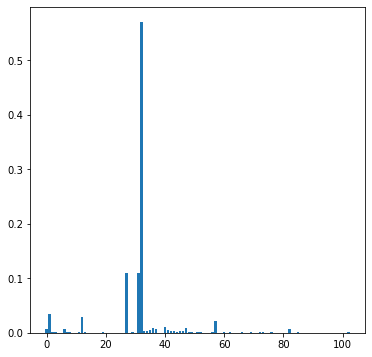

In [142]:
print(Regressor.feature_importances_)
# plot
plt.bar(range(len(Regressor.feature_importances_)), Regressor.feature_importances_)
plt.show()

In [148]:
predictors = [x for x in X_train.columns]

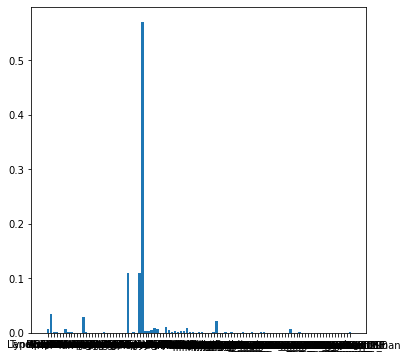

In [149]:
plt.bar(predictors, Regressor.feature_importances_)
plt.show()